Comparing Numpy with Dask for Large Array Creation

In [ ]:
%%time
import numpy as np
a = np.ones((10000,1000,1000))
a

In [1]:
%%time
import dask.array as da
a = da.ones((100000,100000,1000))
a

CPU times: user 143 ms, sys: 58.4 ms, total: 201 ms
Wall time: 373 ms


dask.array<ones_like, shape=(100000, 100000, 1000), dtype=float64, chunksize=(255, 255, 255), chunktype=numpy.ndarray>

## Basics

In [2]:
from time import sleep

def inc(x):
    /
    return x + 1

def add(x,y):
    sleep(1)
    return x + y

In [3]:
%%time

x= inc(1)
y = inc(2)
z = add(x,y)

CPU times: user 1.19 ms, sys: 2.18 ms, total: 3.38 ms
Wall time: 1.01 s


Here, it takes 3 seconds to run because we call each function sequentially

In [4]:
from dask import delayed

In Dask, the delayed function is used to create a lazy computation graph. This means it allows you to define computations without immediately executing them. Instead of running tasks right away, delayed builds a graph of tasks that will be executed later when explicitly triggered.


In [12]:
@delayed
def inc(x):
    sleep(1)
    return x+1

@delayed
def add(x,y):
    sleep(1)
    return x+y

In [13]:
%%time

x= delayed(inc)(1)
y= delayed(inc)(2)
z= delayed(add)(x,y)

CPU times: user 826 μs, sys: 449 μs, total: 1.28 ms
Wall time: 944 μs


In [14]:
z

Delayed('add-783fe011-900e-4deb-bd20-8f0ba039c8c9')

using .visualize() from graphviz

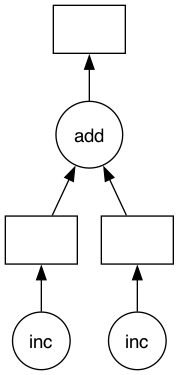

In [15]:
z.visualize()

In [16]:
%%time
z.compute()

CPU times: user 3.64 ms, sys: 4.85 ms, total: 8.49 ms
Wall time: 2.01 s


5

## Parallelizing a for loop

In [14]:
data = [1,2,3,4,5,6,7,8,9,10]

In [15]:
%%time

results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)

CPU times: user 762 μs, sys: 130 μs, total: 892 μs
Wall time: 847 μs


In [16]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)

CPU times: user 450 μs, sys: 162 μs, total: 612 μs
Wall time: 494 μs


In [17]:
total.compute()

65

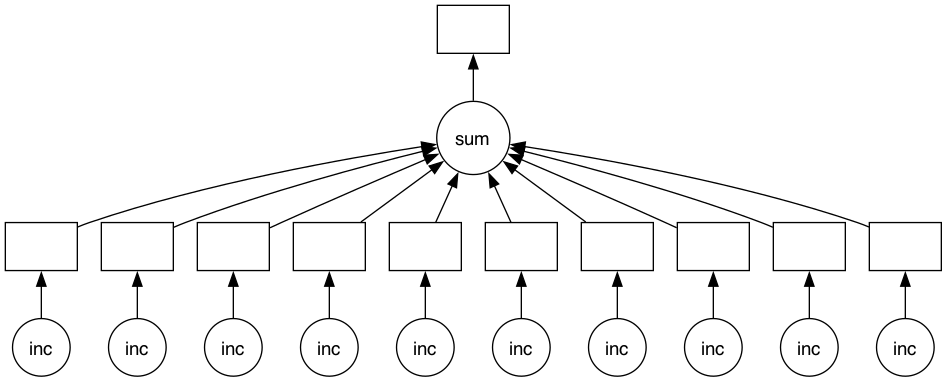

In [18]:
total.visualize()

In [17]:
import pandas as pd
import dask.dataframe as dd
import time
import numpy as np

Reading Large Dataset
Lets read a dataframe with 20 million rows and 3 columns respectively.

In [20]:
pd.DataFrame({
               'A': np.random.randint(0, 100, size=20000000),
               'B': np.random.randint(0, 100, size=20000000),
               'C': np.random.randint(0, 100, size=20000000),
              }).to_csv('dataset.csv', index=False)

In [21]:
start_time = time.time()
df = pd.read_csv('dataset.csv')
pandas_time = time.time() - start_time
print(f"Pandas: shape = {df.shape}, time = {pandas_time} seconds")

Pandas: shape = (20000000, 3), time = 1.011847972869873 seconds


In [22]:
# Read the same file using Dask
start_time = time.time()
dask_df = dd.read_csv('dataset.csv')
dask_time = time.time() - start_time
print(f"Dask: shape = {dask_df.compute().shape}, time = {dask_time} seconds")

Dask: shape = (20000000, 3), time = 0.005926847457885742 seconds


In [23]:
df.head()

,A,B,C
0,19,13,42
1,22,65,8
2,56,19,7
3,22,17,75
4,96,91,18


In [24]:
dask_df.head()

,A,B,C
0,19,13,42
1,22,65,8
2,56,19,7
3,22,17,75
4,96,91,18


## Grouping By and Aggregation

In [25]:
# Time the groupby operation using Pandas
start_time = time.time()
pandas_grouped = df.groupby(['A', 'B']).agg({'C': 'sum'})
pandas_time = time.time() - start_time
print(f"Pandas: Time = {pandas_time} seconds")

Pandas: Time = 0.5185239315032959 seconds


In [26]:
# Time the groupby operation using Dask
start_time = time.time()
dask_groupby = dask_df.groupby(['A', 'B']).agg({'C': 'sum'})
dask_time = time.time() - start_time
print(f"Dask: shape = {dask_df.compute().shape}, Dask: Time = {dask_time} seconds")

Dask: shape = (20000000, 3), Dask: Time = 0.0089569091796875 seconds


## Merging Datasets

In [27]:
# Merge using Pandas
start_time = time.time()
merged_pandas = pd.merge(df, df)
pandas_time = time.time() - start_time
print(f"Pandas: Time = {pandas_time} seconds")

Pandas: Time = 186.33371901512146 seconds


In [28]:
# Merge using Dask
start_time = time.time()
merged_dask = dd.merge(dask_df, dask_df)
dask_time = time.time() - start_time
print(f"Dask: shape = {merged_dask.compute().shape}, Dask: Time = {dask_time} seconds")

Dask: shape = (419946990, 3), Dask: Time = 0.044466257095336914 seconds


## Filtering Data

In [29]:
# Filtering using Pandas
start_time = time.time()
selected_pandas = df[df['A'] > 5000000]
pandas_time = time.time() - start_time
print(f"Pandas: Time = {pandas_time} seconds")

Pandas: Time = 0.24823808670043945 seconds


In [30]:
# Filtering using Dask
start_time = time.time()
selected_dask = dask_df[dask_df['A'] > 5000000]
dask_time = time.time() - start_time
print(f"Dask: Time = {dask_time} seconds")

Dask: Time = 0.012341022491455078 seconds


## Apply Function

In [31]:
# Function to perform Apply on
def my_function(x):
    return x * 2

In [32]:
# Apply a function using Pandas
start_time = time.time()
applied_pandas = df['A'].apply(my_function)
pandas_time = time.time() - start_time
print(f"Pandas: Time = {pandas_time} seconds")

Pandas: Time = 2.3145110607147217 seconds


In [33]:
# Apply a function using Dask
start_time = time.time()
applied_dask = dask_df['A'].map(my_function)
dask_time = time.time() - start_time
print(f"Dask: Time = {dask_time} seconds")

Dask: Time = 0.011747121810913086 seconds


/Users/khushichoudhary/Documents/Math608/venv/lib/python3.12/site-packages/dask_expr/_collection.py:4196: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('A', 'int64'))

  warnings.warn(meta_warning(meta))
